In [15]:
%matplotlib inline

In [16]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import (
    Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv, save_to_json, save_bundle,
    makedir_if_not_there
)

from const import STATE, COLORS, NUM_STATES,  STATES


In [17]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))


In [19]:
def one_run(mean_IM, total_days=360):
    alpha_list = [
        (0, params_before.alpha),
        (days_before_ld, params_after.alpha),
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_ld, params_after.beta),
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_ld],
        k_days=params_after.k_days,
        mean_IM=mean_IM,
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0,
        mu_ei=params_after.mu_ei,
        mu_mo=params_after.mu_mo,
        x0_pt=params_after.x0_pt,          
    )
    
    total, delta, increase, trans, stats = do_simulation(
        total_days, bed_info, p, p0_time=p0_time
    )
    bundle = [total, delta, increase, trans]
    return mean_IM, bundle, stats

In [9]:
total_days = 360

In [20]:
rows = Parallel(n_jobs=-1)(
    delayed(one_run)(mean_IM, total_days)
    for mean_IM in np.arange(4, 9)
)

4
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']


/home/cloud-user/code/covid-19/helpers.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del subdf[state]
/home/cloud-user/code/covid-19/helpers.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

5
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
6
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
7
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
8
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']


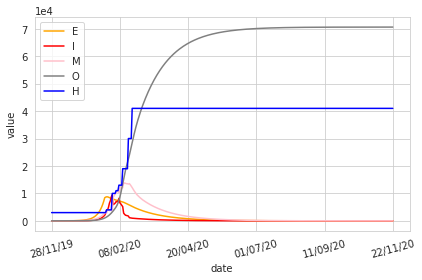

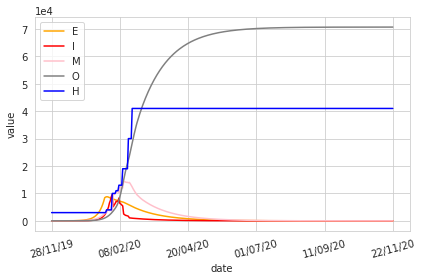

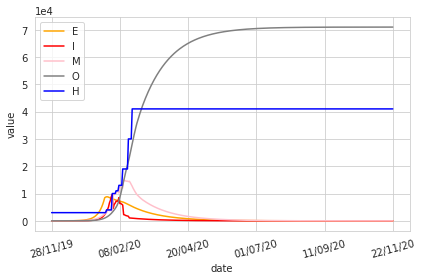

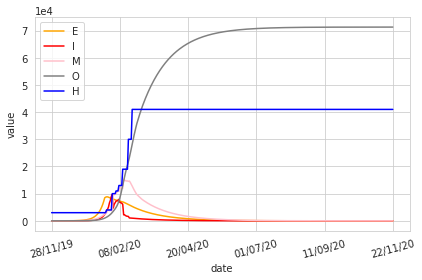

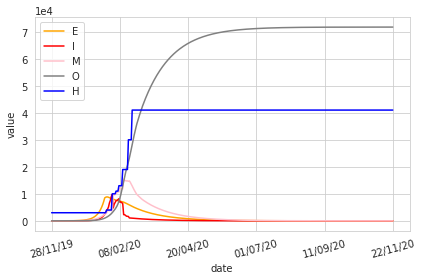

In [22]:
for mean_IM, bundle, stats in rows:    
    print(mean_IM)
    fig, ax = plot_total(bundle[0], p0_time, total_days)
    fig_dir = 'figs/effect-of-mean_IM'
    data_dir = 'output/tbl/effect-of-mean_IM'

    makedir_if_not_there(fig_dir)
    makedir_if_not_there(data_dir)
    
    fig.savefig(f'{fig_dir}/{mean_IM}.pdf')

    save_bundle(bundle, p0_time, total_days, f'{data_dir}/{mean_IM}')
    save_to_json(stats, f'{data_dir}/{mean_IM}/stats.txt')